In [457]:
import pandas as pd
import os
import sys 
import numpy as np
from functools import reduce
import itertools
from ast import literal_eval #converts object list to list of strings
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import statsmodels.api as sm
from statsmodels.formula.api import ols

# this points to a Python file with the function country_mappings (not used)
from combine_country_regions import country_mappings

# not great practice, but this removes warnings from the output
import warnings
warnings.filterwarnings("ignore")

# display settings so I can see more on the screen
desired_width=1000
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',10)
pd.options.display.max_rows = 50

# warnings
import warnings
warnings.filterwarnings("ignore")

# plots
settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5,
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)


In [458]:

#############################################################
# set this to point to your folder or create a new folder,
# (in my case my computer is called jpark and I called the folder trade_warning) 
#############################################################
os.chdir(r'C:\Users\jpark\VisualStudio\Simpsons_BACI\\')
baci_data = r"C:\Users\jpark\Downloads\BACI_HS92_V202401b"


In [472]:

# points to country codes as defined by BACI
COUNTRY_CODES = baci_data + "\country_codes_V202401b.csv"
# point to product codes
PRODUCT_DESCRIPTION = baci_data + "\product_codes_HS92_V202401b.csv"
# add region data, might be better sources
ADD_REGIONS = r"baci_preparation\iso_countries_regions.csv"
# add short HS2 description (could be better descriptions)
SHORT_CODES = r"baci_preparation\hs6twodigits.csv"
# add long product description
LONG_DESCRIPTION = baci_data + "\product_codes_HS22_V202401b.csv"
# add gdp data
GDP_DATA = r"baci_preparation\global_gdp.csv"

class baci:
    '''baci class contains the methods to load baci data and add characteristics such as geographic and strategic'''
    def readindata(self, bacidata, verbose = False, tmp_save = True) -> pd.DataFrame:
        '''main method to read in baci data'''
        df1 = pd.read_csv(bacidata, usecols=['t','i','j','k','v','q'], 
                          dtype= {'t': 'int64',
                                  'i': 'int64', 
                                  'j': 'int64', 
                                  'k': 'object',
                                  'v': 'float64',
                                  'q': 'object'}
                          )

        # This is too complicated, but '   NA' should be converted to float
        df1['q'] = df1['q'].apply(lambda x: x.strip()) # remove spaces in data
        df1['q'].replace('NA', np.NaN, inplace=True)   # np.NaN is different than string NaN
        df1['q'] = df1['q'].astype(float)

        # rename columns to make them meaningful to humans
        df1.rename(columns={'t': 'Year', 'i': 'Exporter', 'j': 'Importer', 'k': 'Product', 'v': 'Value', 'q': 'Quantity'}, inplace=True)

        ROW_COUNT = df1.shape[0]
        print("ROW_COUNT ORIGINAL: ", ROW_COUNT)

        # replace number with name of country *exporter* 
        iso1 = pd.read_csv(COUNTRY_CODES, usecols=['country_code', 'country_iso3'])
        df1 = df1.merge(iso1, left_on="Exporter", right_on="country_code", how="left")
        df1.drop(columns=['country_code', 'Exporter'], inplace = True)
        df1.rename(columns={"country_iso3": "Exporter"}, inplace=True)
    
        # replace number with name of country *importer*
        df1 = df1.merge(iso1, left_on="Importer", right_on="country_code", how="left")
        df1.drop(columns=['country_code', 'Importer'], inplace = True)
        df1.rename(columns={"country_iso3": "Importer"}, inplace=True)

        # 2015 has some strange data, take only Values greater than 10.00, otherwise number of exporting countries in 2015 is an outlier
        df1 = df1[df1['Value'] > 0.00]

        # if verbose is True, this will print out
        if verbose:
            hcodes = [str(x)[0:2] for x in df1["Product"]]
            print(set(hcodes))
            print(len(set(hcodes)))

        # make product code and int, otherwise its an object which can be confusing
        df1['Product'] = df1['Product'].astype(int)    

        ROW_COUNT = df1.shape[0]
        print("ROW_COUNT ORIGINAL2: ", ROW_COUNT)

        return df1
    
    def addprodcode(self, data):
        '''add the product description if needed'''
        # add product_codes
        prodcodes = pd.read_csv(PRODUCT_DESCRIPTION, usecols=['code', 'description'])
        # product '9999AA' appears to be a filler--empty
        mask = prodcodes['code'] == '9999AA'
        prodcodes = prodcodes[~mask]
        # I love merges, note its a left merge, I want all baci data to have a code, but dont care for product codes without products.
        data = data.merge(prodcodes, left_on = "Product", right_on = "code", how = "left")
        
        ROW_COUNT = data.shape[0]
        print("ROW_COUNT addprodcode: ", ROW_COUNT)
        
        return data
    
    def addshortdescriptoProdname(self, data):
        '''Add short product description based on codes'''

        localdata = data.copy()

        # this is necessary because codes 1:9 should be 01:09
        prod_h6 = pd.read_csv(SHORT_CODES, dtype = str)

        # this is necessary because codes 1:9 should be 01:09
        prod_h6.loc[:, 'code'] = ["0" + x if len(x) == 1 else x for x in prod_h6['code'].astype(str)]

        # this is necessary because codes 1:9 should be 01:09
        localdata.loc[:, 'code'] = ["0" + x if len(x) == 5 else x for x in localdata['Product'].astype(str)]

        # get first two numbers
        localdata['shrtDescription'] = localdata['code'].astype(str).str[0:2]
        
        proddesc = localdata.merge(prod_h6, left_on="shrtDescription", right_on="code")
        
        proddesc['product'] = proddesc['product'] + "_" + proddesc['shrtDescription']
        
        proddesc.drop(columns = {'code_x', 'shrtDescription', 'code_y'}, inplace = True)

        proddesc.rename(columns = {"product": "code"}, inplace = True)

        ROW_COUNT = proddesc.shape[0]
        print("ROW_COUNT addshortdescriptoProdname: ", ROW_COUNT)

        return proddesc
    
    def addlongdescription(self, data):
        '''Add product product description based on codes'''
        localdata = data.copy()
        longdesc = pd.read_csv(LONG_DESCRIPTION, dtype = str)

        # this is necessary because codes 1:9 should be 01:09
        localdata.loc[:, 'Product'] = ["0" + x if len(x) == 5 else x for x in localdata['Product'].astype(str)]

        longdesc.rename(columns = {"code": "isocode"}, inplace=True)
        longproddesc = localdata.merge(longdesc, left_on="Product", right_on="isocode", how = 'left', suffixes = ['x', 'y'])
       
        r1 = localdata.shape[0]
        r2 = longproddesc.shape[0]
        assert r1 == r2

        ROW_COUNT = longproddesc.shape[0]
        print("ROW_COUNT addlongdescription: ", ROW_COUNT)

        return longproddesc
    
    def add_gdp(self, data, GDP, year):
        '''Join GDP to data'''

        ### join GDP to data
        
        # Exporters
        gdp = GDP[GDP.index == year]
        gdp = gdp.T
        gdp['Exporter_gdp'] = gdp.index
        
        gdp.rename(columns={year: year + "_gdp_Exporter"}, inplace=True)

        dataj = data.merge(gdp, left_on = "Exporter", right_on = "Exporter_gdp")
        dataj[year + '_gdp_Exporter'] = dataj[year + '_gdp_Exporter']/1e+6
        
        # Importers
        gdp = GDP[GDP.index == year]
        gdp = gdp.T
        gdp['Importer_gdp'] = gdp.index
        gdp.rename(columns={year: year + '_gdp_Importer'}, inplace=True)

        data = dataj.merge(gdp, left_on = "Importer", right_on = "Importer_gdp")
       
        data.drop(columns = ["Exporter_gdp", "Importer_gdp"], inplace=True)

        ROW_COUNT = data.shape[0]
        print("ROW_COUNT add_gdp: ", ROW_COUNT)

        return data
    
    def add_chapter(self, data):
        pass
         

In [460]:

def GDPData():
    '''should alway be run, need to move to BACI class'''
    # https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2022&start=1960&view=chart
    # Taiwan comes from IMF data, added by hand. https://www.imf.org/external/datamapper/NGDPD@WEO/OEMDC/ADVEC/WEOWORLD
    
    data = pd.read_csv(GDP_DATA, index_col=[1], skiprows=4)
    data = data.drop(columns=['Country Name', 'Indicator Code', 'Indicator Name'])
    data = data.T
    return data
GDP = GDPData()
GDP_sum = pd.DataFrame(GDP.sum(axis=1))/1e06
GDP_sum.index = GDP_sum.index.astype("int")
GDP_sum.columns = ["World_GDP"]

In [461]:

# #############################################################
# # INITIALIZE object, needs to be run to create a BACI object instance
bc1 = baci()
# #############################################################

In [462]:
def BACI_through_time():
    years = np.arange(start=1995, stop=2023)

    allYears = []

    for yr in years:
        print(yr)
        bacidata = baci_data + "\BACI_HS92_Y" + str(yr) + "_V202401b.csv"
        test_data = bc1.readindata(bacidata, verbose = False, tmp_save = False)
        test_data = bc1.addshortdescriptoProdname(test_data)

        groupdata = test_data[['Value', 'code']].groupby('code').sum().T
        groupdata['Year'] = yr
        
        allYears.append(groupdata)

    data1 = pd.concat(allYears, axis=0)
    data1.set_index('Year', inplace=True)
    data1.to_csv("tmp123.csv")
    
#BACI_through_time()

In [463]:

data1['TotalTrade'] = data1.sum(axis=1)
data2 = data1.merge(GDP_sum, left_index=True, right_index=True)
data2['TradeRatioGDP'] = data2['TotalTrade']/data2['World_GDP']
data2

,aircraft spacecraft_88,albuminoidal substances_35,aluminium and articles thereof_76,animal_orginated_products_05,animal_vegetable_fats_15,...,works of art collectors pieces_97,zinc and articles thereof_79,TotalTrade,World_GDP,TradeRatioGDP
1995,6.788237e+07,8.693783e+06,6.194809e+07,4.051236e+06,3.062783e+07,...,6.561453e+06,5.097880e+06,5.501177e+10,2.307468e+08,238.407530
1996,7.552393e+07,9.210330e+06,5.871168e+07,4.245974e+06,2.953505e+07,...,6.422786e+06,5.211478e+06,5.823589e+10,2.381542e+08,244.530249
1997,8.606628e+07,9.348892e+06,6.237430e+07,4.255718e+06,3.145668e+07,...,7.729994e+06,7.087211e+06,6.049344e+10,2.380886e+08,254.079487
1998,1.106983e+08,9.774738e+06,6.311034e+07,4.152013e+06,3.317873e+07,...,8.085025e+06,6.321274e+06,5.996338e+10,2.378218e+08,252.135755
1999,1.124921e+08,9.600234e+06,6.188064e+07,3.790889e+06,2.898761e+07,...,8.243764e+06,6.381087e+06,6.207540e+10,2.420476e+08,256.459450
2000,1.130735e+08,1.001220e+07,6.956053e+07,3.980089e+06,2.452699e+07,...,1.008979e+07,6.983765e+06,7.026261e+10,2.503799e+08,280.624061
2001,1.204398e+08,1.060027e+07,6.840142e+07,3.743160e+06,2.403610e+07,...,9.699231e+06,6.108655e+06,6.808002e+10,2.497043e+08,272.642569
2002,1.184746e+08,1.118113e+07,7.039954e+07,3.973917e+06,2.993630e+07,...,9.628895e+06,5.828726e+06,7.125852e+10,2.596720e+08,274.417388
2003,1.196348e+08,1.309460e+07,7.914610e+07,4.435524e+06,3.736264e+07,...,9.416440e+06,6.365470e+06,8.286419e+10,2.929229e+08,282.887337
2004,1.247985e+08,1.502484e+07,9.863755e+07,5.143938e+06,4.407303e+07,...,1.192202e+07,7.944534e+06,1.000700e+11,3.329515e+08,300.554219


<Axes: >

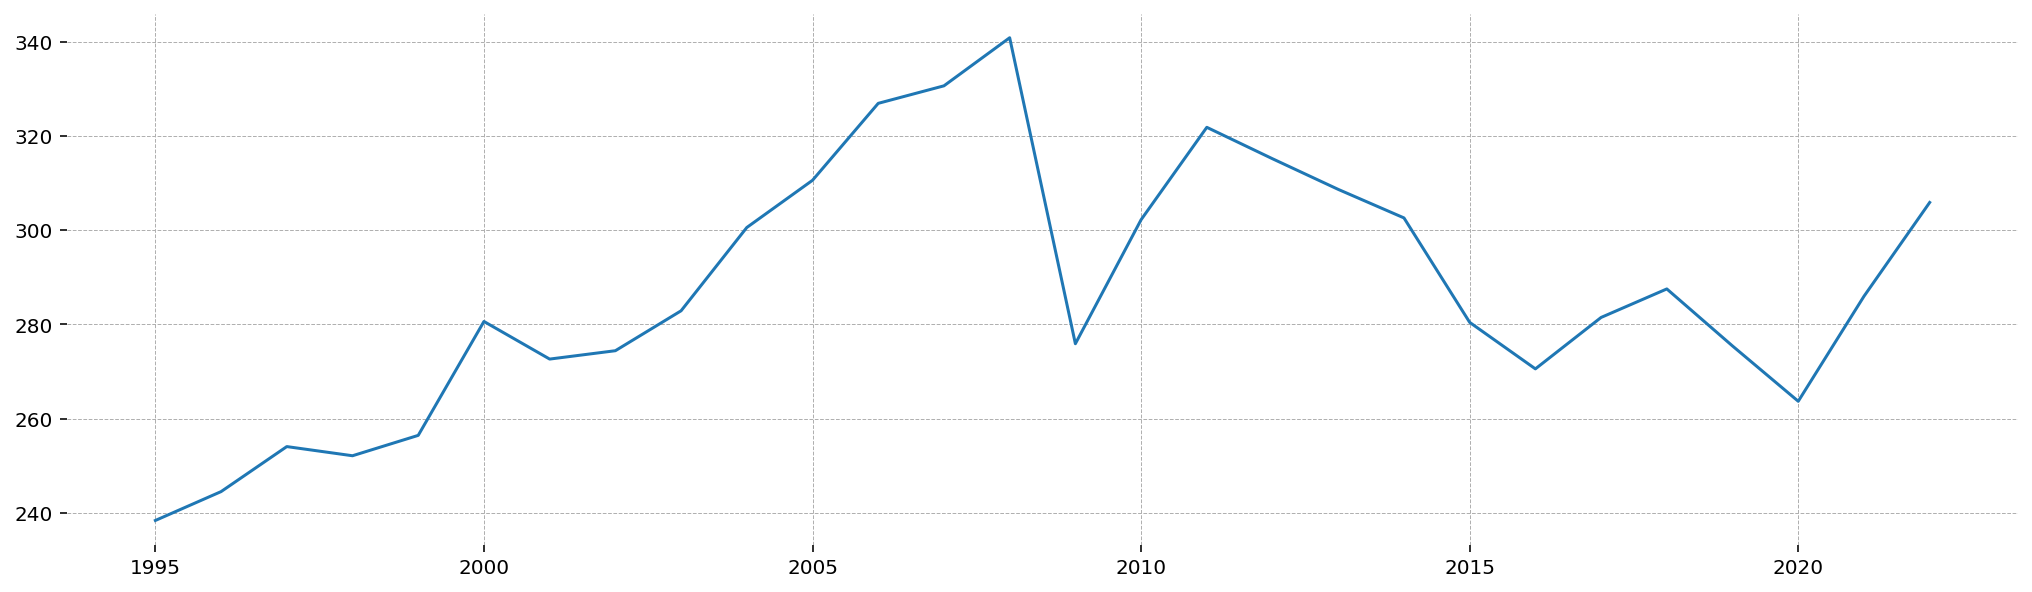

In [464]:
data2['TradeRatioGDP'].plot()

### Percent for each sector

In [465]:
data3 = data2.drop(columns=['TotalTrade', 'TradeRatioGDP'])

data3.head()

,aircraft spacecraft_88,albuminoidal substances_35,aluminium and articles thereof_76,animal_orginated_products_05,animal_vegetable_fats_15,...,wood and articles of wood_44,wool fine or coarse_51,works of art collectors pieces_97,zinc and articles thereof_79,World_GDP
1995,6.788237e+07,8693783.308,6.194809e+07,4051236.431,3.062783e+07,...,6.995624e+07,1.557253e+07,6561453.155,5097880.056,2.307468e+08
1996,7.552393e+07,9210329.704,5.871168e+07,4245973.718,2.953505e+07,...,7.098472e+07,1.518373e+07,6422786.408,5211477.587,2.381542e+08
1997,8.606628e+07,9348891.861,6.237430e+07,4255718.373,3.145668e+07,...,7.358429e+07,1.540856e+07,7729994.392,7087211.197,2.380886e+08
1998,1.106983e+08,9774738.306,6.311034e+07,4152013.007,3.317873e+07,...,6.611056e+07,1.277718e+07,8085024.891,6321274.330,2.378218e+08
1999,1.124921e+08,9600234.187,6.188064e+07,3790888.592,2.898761e+07,...,7.187825e+07,1.142173e+07,8243763.965,6381086.520,2.420476e+08


<Axes: >

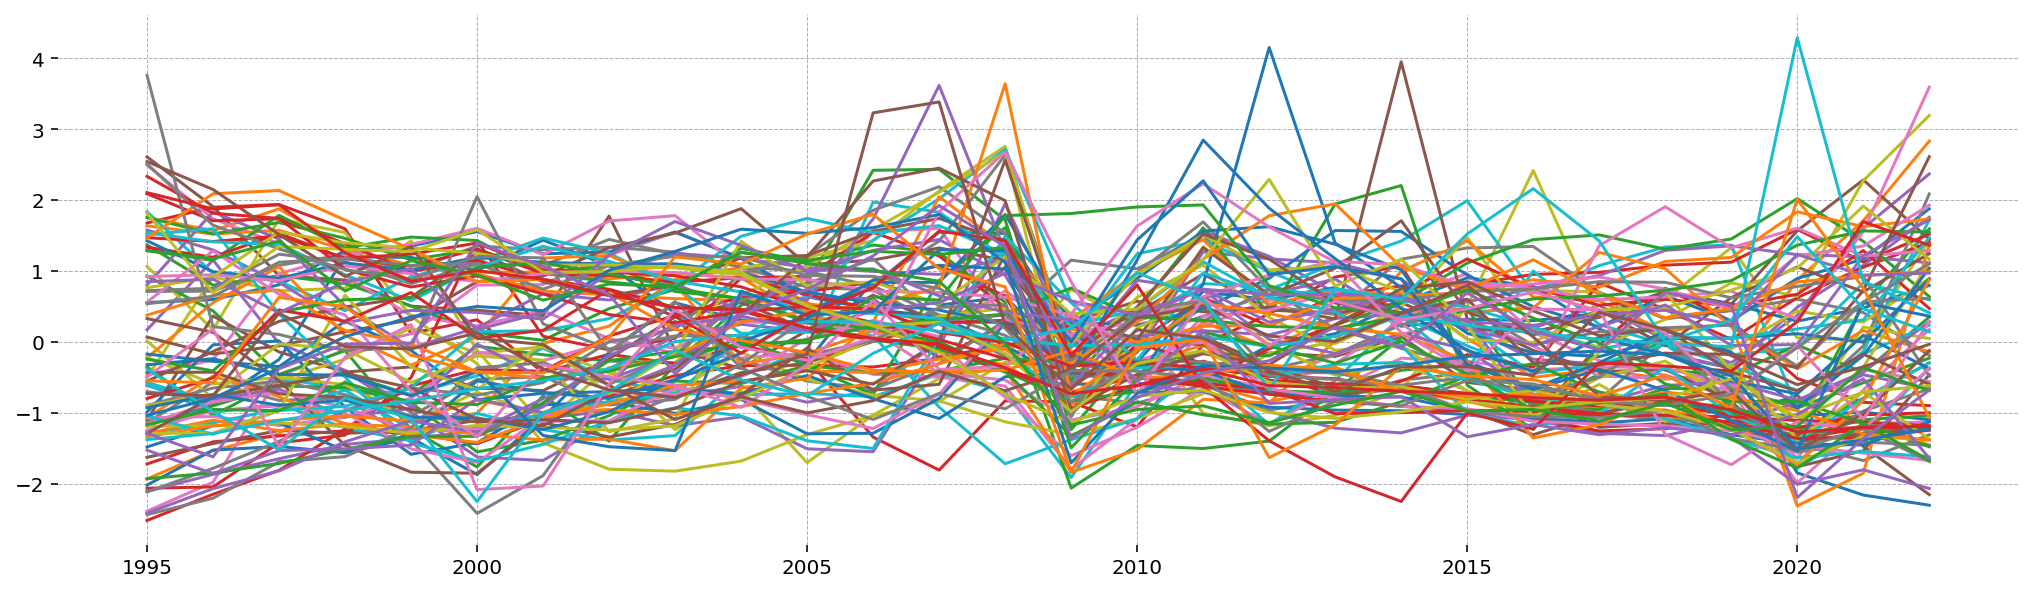

In [466]:
data4 = data3.iloc[:,:-1].div(data3.World_GDP, axis=0)
data5 = (data4 - data4.mean())/data4.std()
data5.plot(legend = False)

### Add Chapter

In [467]:
PRODUCT_DESCRIPTION = baci_data + "\product_codes_HS92_V202401b.csv"

prod_desc = pd.read_csv(PRODUCT_DESCRIPTION)
prod_desc['Chapter'] = np.nan

In [468]:
searchfor = ['01','02','03','04','05']
prod_desc1 = prod_desc['code'].apply(lambda x: 'I' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc1.dropna(inplace=True)

searchfor = ['06','07','08','09','10','11','12','13','14']
prod_desc2 = prod_desc['code'].apply(lambda x: 'II' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc2.dropna(inplace=True)

searchfor = ['15']
prod_desc3 = prod_desc['code'].apply(lambda x: 'III' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc3.dropna(inplace=True)

searchfor = ['16','17','18','19','20','21','22','23','24']
prod_desc4 = prod_desc['code'].apply(lambda x: 'IV' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc4.dropna(inplace=True)

searchfor = ['25','26','27']
prod_desc5 = prod_desc['code'].apply(lambda x: 'V' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc5.dropna(inplace=True)

searchfor = ['28','29','30','31','32','33','34','35','36','37','38']
prod_desc6 = prod_desc['code'].apply(lambda x: 'VI' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc6.dropna(inplace=True)

searchfor = ['39','40']
prod_desc7 = prod_desc['code'].apply(lambda x: 'VII' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc7.dropna(inplace=True)

searchfor = ['41','42','43']
prod_desc8 = prod_desc['code'].apply(lambda x: 'VIII' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc8.dropna(inplace=True)

searchfor = ['44','45','46']
prod_desc9 = prod_desc['code'].apply(lambda x: 'IX' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc9.dropna(inplace=True)

searchfor = ['47','48','49']
prod_desc10 = prod_desc['code'].apply(lambda x: 'X' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc10.dropna(inplace=True)

searchfor = ['50','51','52','53','54','55','56','57','58','59','60','61','62','63']
prod_desc11 = prod_desc['code'].apply(lambda x: 'XI' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc11.dropna(inplace=True)

searchfor = ['64','65','66','67']
prod_desc12 = prod_desc['code'].apply(lambda x: 'XII' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc12.dropna(inplace=True)

searchfor = ['68','69','70']
prod_desc13 = prod_desc['code'].apply(lambda x: 'XIII' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc13.dropna(inplace=True)

searchfor = ['71']
prod_desc14 = prod_desc['code'].apply(lambda x: 'XIV' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc14.dropna(inplace=True)

searchfor = ['72','73','74','75','76','77','78','79','80','81','82','83']
prod_desc15 = prod_desc['code'].apply(lambda x: 'XV' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc15.dropna(inplace=True)

searchfor = ['84','85']
prod_desc16 = prod_desc['code'].apply(lambda x: 'XVI' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc16.dropna(inplace=True)

searchfor = ['86','87','88','89']
prod_desc17 = prod_desc['code'].apply(lambda x: 'XVII' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc17.dropna(inplace=True)

searchfor = ['90','91','92']
prod_desc18 = prod_desc['code'].apply(lambda x: 'XVIII' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc18.dropna(inplace=True)

searchfor = ['93']
prod_desc19 = prod_desc['code'].apply(lambda x: 'XIX' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc19.dropna(inplace=True)

searchfor = ['94','95','96']
prod_desc20 = prod_desc['code'].apply(lambda x: 'XX' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc20.dropna(inplace=True)

searchfor = ['97']
prod_desc21 = prod_desc['code'].apply(lambda x: 'XXI' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc21.dropna(inplace=True)

searchfor = ['99']
prod_desc22 = prod_desc['code'].apply(lambda x: 'missing' if any(i in x[0:2] for i in searchfor) else np.nan)
prod_desc22.dropna(inplace=True)

xyz = pd.concat([prod_desc1, prod_desc2,prod_desc3,prod_desc4,prod_desc5,prod_desc6,prod_desc7,
           prod_desc8,prod_desc9,prod_desc10,prod_desc11,prod_desc12,prod_desc13,prod_desc14,
           prod_desc15,prod_desc16,prod_desc17,prod_desc18,prod_desc19,prod_desc20,prod_desc21,prod_desc22])


prod_desc['Chapter'] = xyz
hs6twodigits_new = prod_desc.copy()

hs6twodigits_new.drop(columns=['code'], inplace=True)
hs6twodigits_new.rename(columns={"Chapter": "product"}, inplace=True)
hs6twodigits_new  = hs6twodigits_new[hs6twodigits_new['product'] != 'missing']

hs6twodigits_new.to_csv("baci_preparation\hs6twodigits_new.csv")

In [469]:
hs6twodigits_new.head()

,description,product
0,"Horses: live, pure-bred breeding animals",I
1,"Horses: live, other than pure-bred breeding an...",I
2,"Asses, mules and hinnies: live",I
3,"Bovine animals: live, pure-bred breeding animals",I
4,"Bovine animals: live, other than pure-bred bre...",I


In [473]:
def BACI_through_time_chapter():
    years = np.arange(start=1995, stop=1996)

    allYears = []

    for yr in years:
        print(yr)
        bacidata = baci_data + "\BACI_HS92_Y" + str(yr) + "_V202401b.csv"
        test_data = bc1.readindata(bacidata, verbose = False, tmp_save = False)
        test_data = bc1.addshortdescriptoProdname(test_data)

        groupdata = test_data[['Value', 'code']].groupby('code').sum().T
        groupdata['Year'] = yr
        
        allYears.append(groupdata)

    data1 = pd.concat(allYears, axis=0)
    data1.set_index('Year', inplace=True)
    data1.to_csv("tmp123.csv")
    

    
BACI_through_time_chapter()

1995
ROW_COUNT ORIGINAL:  4981382
ROW_COUNT ORIGINAL2:  4981382
ROW_COUNT addshortdescriptoProdname:  4981382
